In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Msun = 1.988*1e30
kpc = 3.086*1e16

# ok, lets test tha tidal stripping at peri
Msun = 1.988*1e30 # msun in kg
kpc = 3.086*1e16 # kpc in m
G = 4.3*1e-6 # kpc/M_sun km^2/s^2
DMmass = sim['SnapNumber_128/Header/MassTable'][1]

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def getMet(idd, iddC, snap):
    # get tidal form anything around , lets say I dont know, what i think is close
    # 200 kpc is almost the virial radius, so 100 kpc should be good, and the center always, obviously.
    
    optRadius = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
    offStars = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
    offGas = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
    
    posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    posPart = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][offStars[0]:offStars[1]]
    rpart = np.sqrt((posPart[:,0] - posGal[0])**2+(posPart[:,1] - posGal[1])**2+(posPart[:,2] - posGal[2])**2)
    index = np.arange(offStars[0], offStars[1])
    ii = np.where(rpart<optRadius)[0]
    indexR = index[ii]
    
    Abund = sim['SnapNumber_{}/PartType4/Abundances'.format(snap)][indexR]
    
    TFeH = np.log10((Abund[:,4]/FeMass)/(Abund[:,6]/HMass)) - NfeNhe_sun
    TOFe = np.log10((Abund[:,3]/OMass)/(Abund[:,4]/FeMass)) - NoNfe_sun
    
    ife = np.where((np.isnan(TFeH)==False) & (np.isinf(TFeH)==False))
    io = np.where((np.isnan(TOFe)==False) & (np.isinf(TOFe)==False))
    
    TFeH = TFeH[ife]
    TOFe = TOFe[io]
    
    STMass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][indexR]
    
    posPartG = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offGas[0]:offGas[1]]
    rpartG = np.sqrt((posPartG[:,0] - posGal[0])**2+(posPartG[:,1] - posGal[1])**2+(posPartG[:,2] - posGal[2])**2)
    indexG = np.arange(offGas[0], offGas[1])
    iiG = np.where(rpartG<optRadius)[0]
    indexGR = indexG[iiG]
    
    sfr = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][indexGR]
    sSFR = np.sum(sfr)/np.sum(STMass*1e10)
    
    return np.median(TFeH), np.median(TOFe), sSFR

def getMetTime(gal, central):
    
    FeH, OFe, sSFR, snaplist = [], [], [], []
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][central]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    uniqueID = int(127*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(127*1e6+central)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    ccc = 0
    for m, mC in zip(mtree, mtreeC):
        
        snap, idd = split_unique_id(int(m))
        snap, iddC = split_unique_id(int(mC))
        
        gTemp = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200T = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][gTemp]
        
        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        groupPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        pos = np.sqrt(np.sum((galPos-groupPos)**2))
        
        if pos>2*r200T:
            break
        
        tFeH, tOFe, tsSFR = getMet(idd, iddC, snap)
        
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        
        snaplist.append(snap)
        FeH.append(tFeH)
        OFe.append(tOFe)
        sSFR.append(tsSFR)
        
    FeH, OFe, sSFR, snaplist = np.array(FeH), np.array(OFe), np.array(sSFR), np.array(snaplist)
    
    return FeH, OFe, sSFR

In [5]:
FeH_4338, OFe_4338, sSFR_4338 = getMetTime(4338, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [6]:
FeH_4339, OFe_4339, sSFR_4339 = getMetTime(4339, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [7]:
FeH_4341, OFe_4341, sSFR_4341 = getMetTime(4341, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [8]:
FeH_4343, OFe_4343, sSFR_4343 = getMetTime(4343, 4337)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [9]:
FeH_4470, OFe_4470, sSFR_4470 = getMetTime(4470, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [10]:
FeH_4471, OFe_4471, sSFR_4471 = getMetTime(4471, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [11]:
FeH_4473, OFe_4473, sSFR_4473 = getMetTime(4473, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [12]:
FeH_4474, OFe_4474, sSFR_4474 = getMetTime(4474, 4469)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [13]:
def smoother(sSFR, FeH, OFe, n):
    I = np.arange(sSFR.size)
    
    newsSFR, newFeH, newOFe = np.zeros(I.size), np.zeros(I.size), np.zeros(I.size)
    for i in I:
        itemp = np.arange(i-n, i+n+1)
        itemp = itemp[np.where((itemp>=0) & (itemp<I[-1]))]
        tsSFR = sSFR[itemp]
        tFeH = FeH[itemp]
        tOFe = OFe[itemp]
        
        tsSFR = tsSFR[np.where((np.isnan(tsSFR)==False) & (np.isinf(tsSFR)==False))]
        tFeH = tFeH[np.where((np.isnan(tFeH)==False) & (np.isinf(tFeH)==False))]
        tOFe = tOFe[np.where((np.isnan(tOFe)==False) & (np.isinf(tOFe)==False))]
        
        newsSFR[i] = np.mean(tsSFR)
        newFeH[i] = np.mean(tFeH)
        newOFe[i] = np.mean(tOFe)
        
    return newsSFR, newFeH, newOFe

In [14]:
nFeH_4338 = FeH_4338[:-1]
nFeH_4339 = FeH_4339[:-1]
nFeH_4341 = FeH_4341[:-1]
nFeH_4343 = FeH_4343[:-1]

nFeH_4470 = FeH_4470[:-1]
nFeH_4471 = FeH_4471[:-1]
nFeH_4473 = FeH_4473[:-1]
nFeH_4474 = FeH_4474[:-1]

nOFe_4338 = OFe_4338[:-1]
nOFe_4339 = OFe_4339[:-1]
nOFe_4341 = OFe_4341[:-1]
nOFe_4343 = OFe_4343[:-1]

nOFe_4470 = OFe_4470[:-1]
nOFe_4471 = OFe_4471[:-1]
nOFe_4473 = OFe_4473[:-1]
nOFe_4474 = OFe_4474[:-1]

nsSFR_4338 = sSFR_4338[1:]
nsSFR_4339 = sSFR_4339[1:]
nsSFR_4341 = sSFR_4341[1:]
nsSFR_4343 = sSFR_4343[1:]

nsSFR_4470 = sSFR_4470[1:]
nsSFR_4471 = sSFR_4471[1:]
nsSFR_4473 = sSFR_4473[1:]
nsSFR_4474 = sSFR_4474[1:]

In [15]:
n = 3

nnewsSFR_4338, nnewFeH_4338, nnewOFe_4338 = smoother(nsSFR_4338, nFeH_4338, nOFe_4338, n)
nnewsSFR_4339, nnewFeH_4339, nnewOFe_4339 = smoother(nsSFR_4339, nFeH_4339, nOFe_4339, n)
nnewsSFR_4341, nnewFeH_4341, nnewOFe_4341 = smoother(nsSFR_4341, nFeH_4341, nOFe_4341, n)
nnewsSFR_4343, nnewFeH_4343, nnewOFe_4343 = smoother(nsSFR_4343, nFeH_4343, nOFe_4343, n)

nnewsSFR_4470, nnewFeH_4470, nnewOFe_4470 = smoother(nsSFR_4470, nFeH_4470, nOFe_4470, n)
nnewsSFR_4471, nnewFeH_4471, nnewOFe_4471 = smoother(nsSFR_4471, nFeH_4471, nOFe_4471, n)
nnewsSFR_4473, nnewFeH_4473, nnewOFe_4473 = smoother(nsSFR_4473, nFeH_4473, nOFe_4473, n)
nnewsSFR_4474, nnewFeH_4474, nnewOFe_4474 = smoother(nsSFR_4474, nFeH_4474, nOFe_4474, n)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, 'Stellar [O/Fe]')

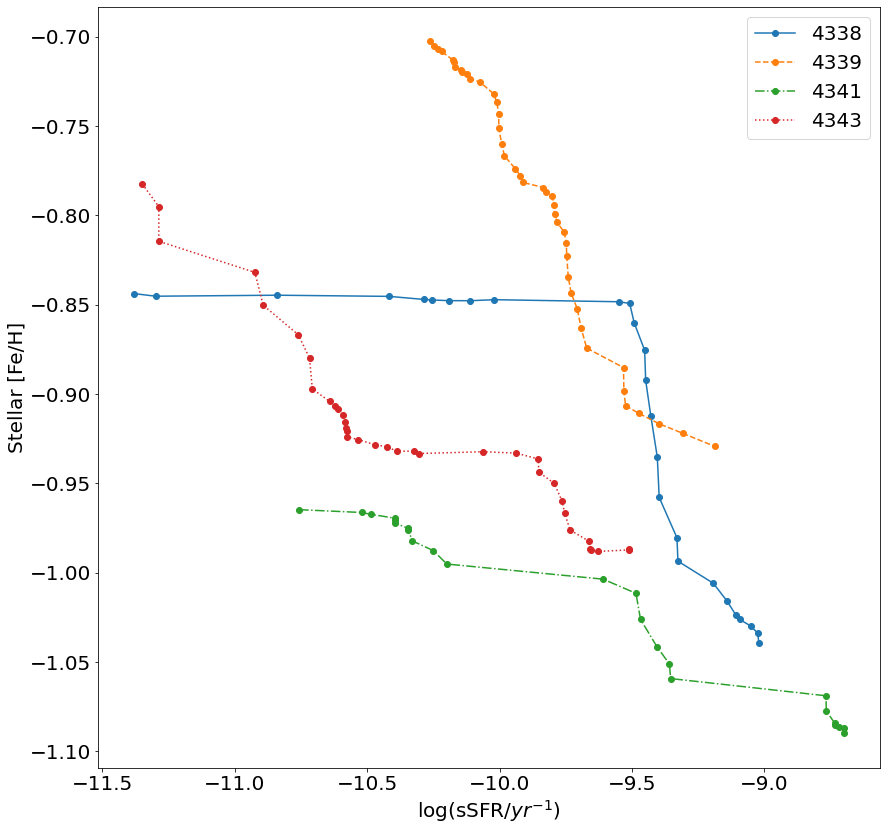

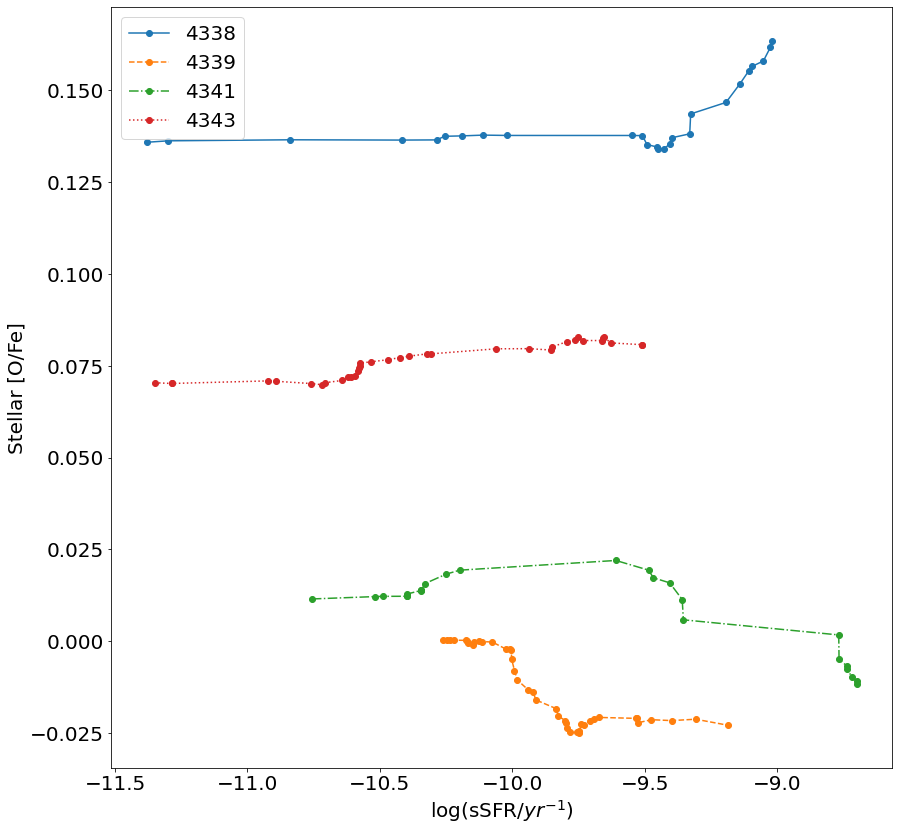

In [16]:
pl.figure(figsize=(14,14))

ii_4338 = np.argsort(nnewsSFR_4338)
ii_4339 = np.argsort(nnewsSFR_4339)
ii_4341 = np.argsort(nnewsSFR_4341)
ii_4343 = np.argsort(nnewsSFR_4343)

pl.plot(np.log10(nnewsSFR_4338[ii_4338]), nnewFeH_4338, label='4338', marker='o',ls='-')
pl.plot(np.log10(nnewsSFR_4339[ii_4339]), nnewFeH_4339, label='4339', marker='o',ls='--')
pl.plot(np.log10(nnewsSFR_4341[ii_4341]), nnewFeH_4341, label='4341', marker='o',ls='-.')
pl.plot(np.log10(nnewsSFR_4343[ii_4343]), nnewFeH_4343, label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\log($sSFR$/yr^{-1})$')
pl.ylabel('Stellar [Fe/H]')

pl.figure(figsize=(14,14))

pl.plot(np.log10(nnewsSFR_4338[ii_4338]), nnewOFe_4338, label='4338', marker='o',ls='-')
pl.plot(np.log10(nnewsSFR_4339[ii_4339]), nnewOFe_4339, label='4339', marker='o',ls='--')
pl.plot(np.log10(nnewsSFR_4341[ii_4341]), nnewOFe_4341, label='4341', marker='o',ls='-.')
pl.plot(np.log10(nnewsSFR_4343[ii_4343]), nnewOFe_4343, label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\log($sSFR$/yr^{-1})$')
pl.ylabel('Stellar [O/Fe]')

Text(0, 0.5, 'Stellar [O/Fe]')

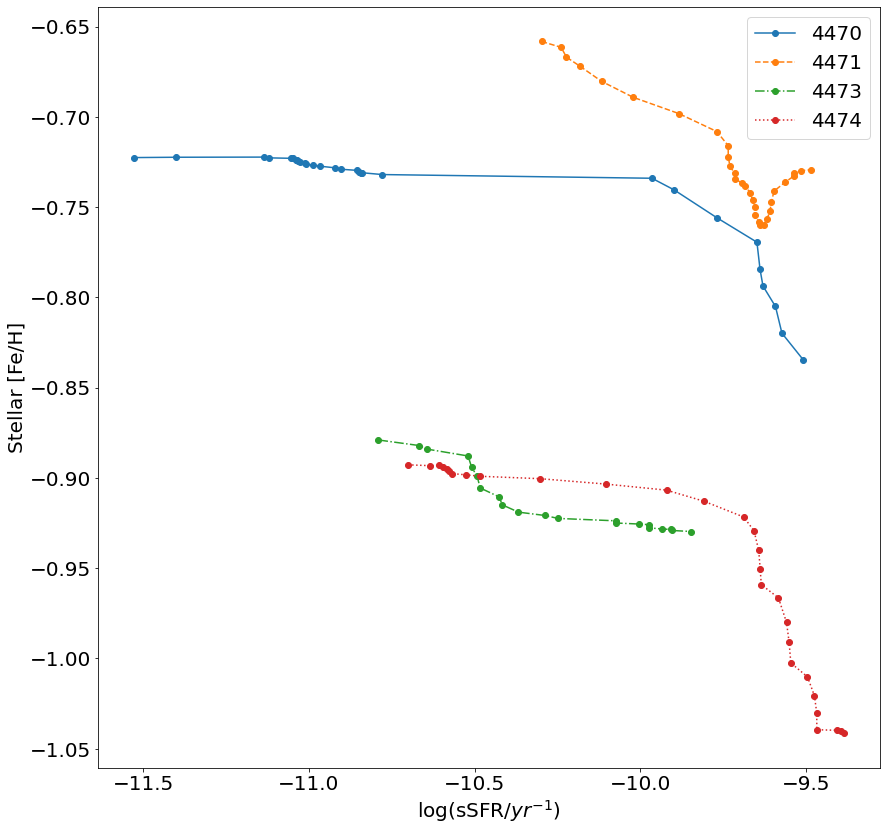

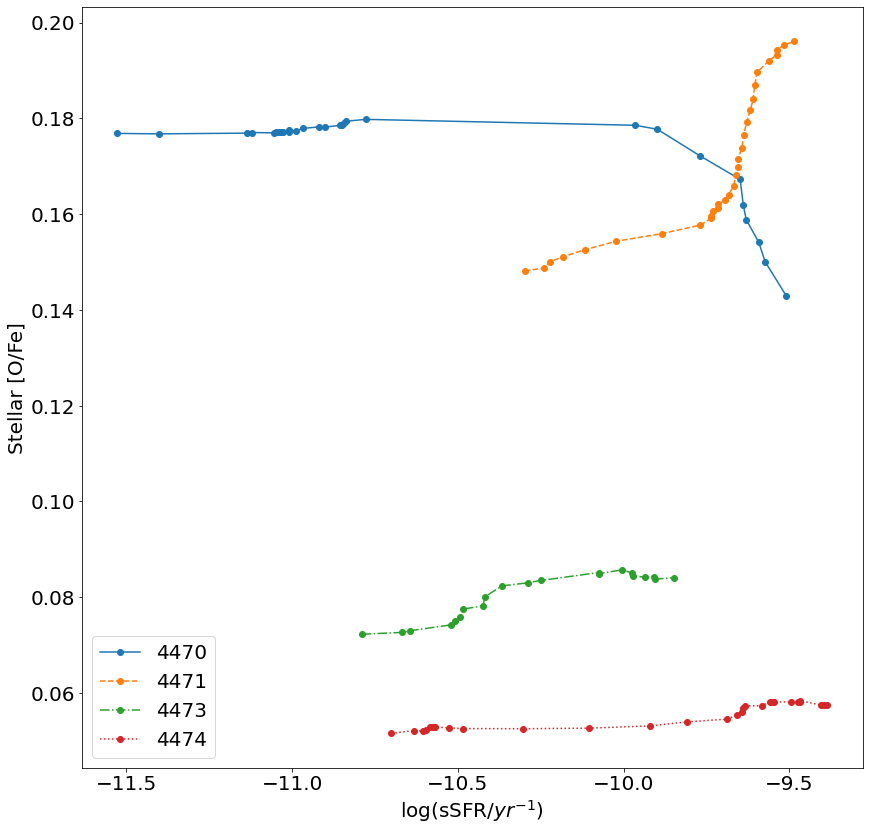

In [17]:
pl.figure(figsize=(14,14))

ii_4470 = np.argsort(nnewsSFR_4470)
ii_4471 = np.argsort(nnewsSFR_4471)
ii_4473 = np.argsort(nnewsSFR_4473)
ii_4474 = np.argsort(nnewsSFR_4474)

pl.plot(np.log10(nnewsSFR_4470[ii_4470]), nnewFeH_4470, label='4470', marker='o',ls='-')
pl.plot(np.log10(nnewsSFR_4471[ii_4471]), nnewFeH_4471, label='4471', marker='o',ls='--')
pl.plot(np.log10(nnewsSFR_4473[ii_4473]), nnewFeH_4473, label='4473', marker='o',ls='-.')
pl.plot(np.log10(nnewsSFR_4474[ii_4474]), nnewFeH_4474, label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\log($sSFR$/yr^{-1})$')
pl.ylabel('Stellar [Fe/H]')

pl.figure(figsize=(14,14))

pl.plot(np.log10(nnewsSFR_4470[ii_4470]), nnewOFe_4470, label='4470', marker='o',ls='-')
pl.plot(np.log10(nnewsSFR_4471[ii_4471]), nnewOFe_4471, label='4471', marker='o',ls='--')
pl.plot(np.log10(nnewsSFR_4473[ii_4473]), nnewOFe_4473, label='4473', marker='o',ls='-.')
pl.plot(np.log10(nnewsSFR_4474[ii_4474]), nnewOFe_4474, label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\log($sSFR$/yr^{-1})$')
pl.ylabel('Stellar [O/Fe]')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, 'Stellar [Fe/H]')

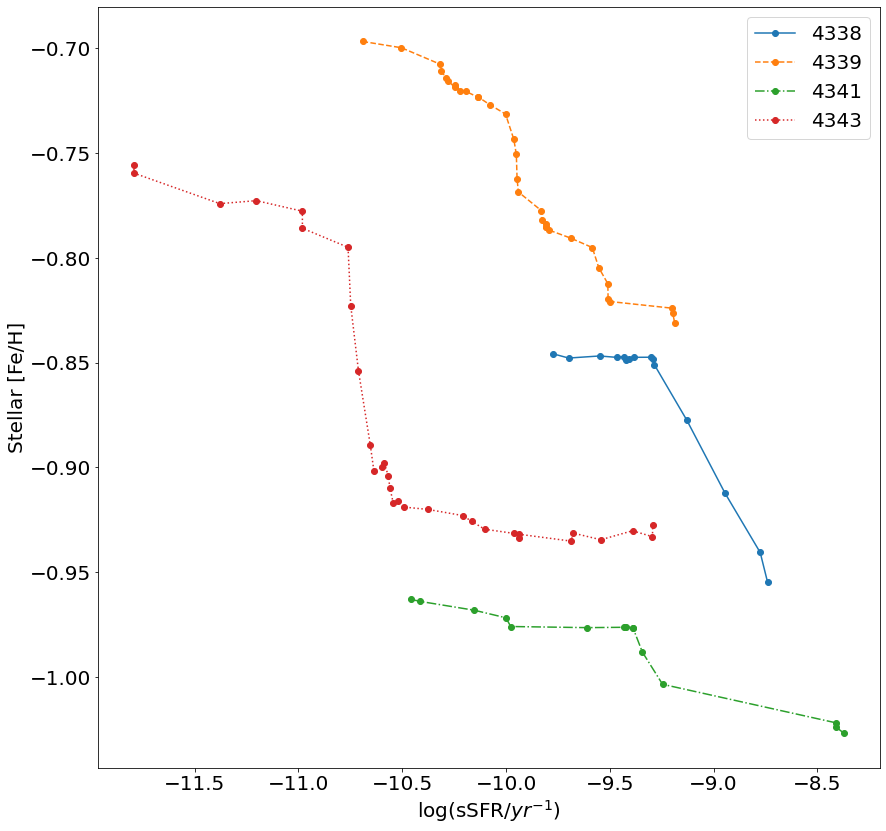

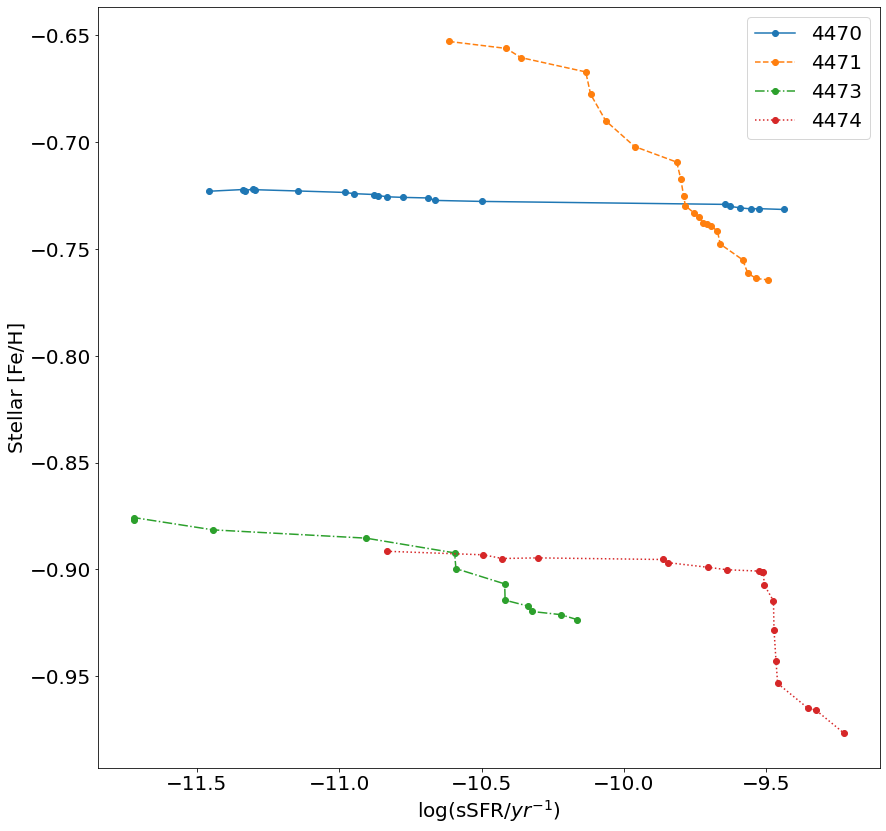

In [20]:
spaceD = 10

nFeH_4338 = FeH_4338[:-spaceD]
nFeH_4339 = FeH_4339[:-spaceD]
nFeH_4341 = FeH_4341[:-spaceD]
nFeH_4343 = FeH_4343[:-spaceD]

nFeH_4470 = FeH_4470[:-spaceD]
nFeH_4471 = FeH_4471[:-spaceD]
nFeH_4473 = FeH_4473[:-spaceD]
nFeH_4474 = FeH_4474[:-spaceD]

nOFe_4338 = OFe_4338[:-spaceD]
nOFe_4339 = OFe_4339[:-spaceD]
nOFe_4341 = OFe_4341[:-spaceD]
nOFe_4343 = OFe_4343[:-spaceD]

nOFe_4470 = OFe_4470[:-spaceD]
nOFe_4471 = OFe_4471[:-spaceD]
nOFe_4473 = OFe_4473[:-spaceD]
nOFe_4474 = OFe_4474[:-spaceD]

nsSFR_4338 = sSFR_4338[spaceD:]
nsSFR_4339 = sSFR_4339[spaceD:]
nsSFR_4341 = sSFR_4341[spaceD:]
nsSFR_4343 = sSFR_4343[spaceD:]

nsSFR_4470 = sSFR_4470[spaceD:]
nsSFR_4471 = sSFR_4471[spaceD:]
nsSFR_4473 = sSFR_4473[spaceD:]
nsSFR_4474 = sSFR_4474[spaceD:]

n = 1

nnewsSFR_4338, nnewFeH_4338, nnewOFe_4338 = smoother(nsSFR_4338, nFeH_4338, nOFe_4338, n)
nnewsSFR_4339, nnewFeH_4339, nnewOFe_4339 = smoother(nsSFR_4339, nFeH_4339, nOFe_4339, n)
nnewsSFR_4341, nnewFeH_4341, nnewOFe_4341 = smoother(nsSFR_4341, nFeH_4341, nOFe_4341, n)
nnewsSFR_4343, nnewFeH_4343, nnewOFe_4343 = smoother(nsSFR_4343, nFeH_4343, nOFe_4343, n)

nnewsSFR_4470, nnewFeH_4470, nnewOFe_4470 = smoother(nsSFR_4470, nFeH_4470, nOFe_4470, n)
nnewsSFR_4471, nnewFeH_4471, nnewOFe_4471 = smoother(nsSFR_4471, nFeH_4471, nOFe_4471, n)
nnewsSFR_4473, nnewFeH_4473, nnewOFe_4473 = smoother(nsSFR_4473, nFeH_4473, nOFe_4473, n)
nnewsSFR_4474, nnewFeH_4474, nnewOFe_4474 = smoother(nsSFR_4474, nFeH_4474, nOFe_4474, n)

pl.figure(figsize=(14,14))

ii_4338 = np.argsort(nnewsSFR_4338)
ii_4339 = np.argsort(nnewsSFR_4339)
ii_4341 = np.argsort(nnewsSFR_4341)
ii_4343 = np.argsort(nnewsSFR_4343)

pl.plot(np.log10(nnewsSFR_4338[ii_4338]), nnewFeH_4338, label='4338', marker='o',ls='-')
pl.plot(np.log10(nnewsSFR_4339[ii_4339]), nnewFeH_4339, label='4339', marker='o',ls='--')
pl.plot(np.log10(nnewsSFR_4341[ii_4341]), nnewFeH_4341, label='4341', marker='o',ls='-.')
pl.plot(np.log10(nnewsSFR_4343[ii_4343]), nnewFeH_4343, label='4343', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\log($sSFR$/yr^{-1})$')
pl.ylabel('Stellar [Fe/H]')


pl.figure(figsize=(14,14))

ii_4470 = np.argsort(nnewsSFR_4470)
ii_4471 = np.argsort(nnewsSFR_4471)
ii_4473 = np.argsort(nnewsSFR_4473)
ii_4474 = np.argsort(nnewsSFR_4474)

pl.plot(np.log10(nnewsSFR_4470[ii_4470]), nnewFeH_4470, label='4470', marker='o',ls='-')
pl.plot(np.log10(nnewsSFR_4471[ii_4471]), nnewFeH_4471, label='4471', marker='o',ls='--')
pl.plot(np.log10(nnewsSFR_4473[ii_4473]), nnewFeH_4473, label='4473', marker='o',ls='-.')
pl.plot(np.log10(nnewsSFR_4474[ii_4474]), nnewFeH_4474, label='4474', marker='o',ls=':')

pl.legend(loc='best')

pl.xlabel('$\log($sSFR$/yr^{-1})$')
pl.ylabel('Stellar [Fe/H]')